In [1]:
from scipy.io import loadmat
from sklearn import svm
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import numpy as np
import scipy.stats
import scipy.signal
from scipy.signal import find_peaks
import scipy as sp
from scipy.interpolate import interp1d

import os

In [2]:
def shannon_entropy(signal):
    """Calculate the Shannon entropy of a signal."""
    probability_distribution, _ = np.histogram(signal, bins='fd', density=True)
    probability_distribution = probability_distribution[probability_distribution > 0]
    entropy = -np.sum(probability_distribution * np.log2(probability_distribution))
    return entropy


def higuchi_fd(signal, kmax=10):
    """Calculate the Higuchi Fractal Dimension of a signal."""
    N = len(signal)
    Lk = np.zeros((kmax,))

    for k in range(1, kmax + 1):
        Lmk = np.zeros((k,))
        for m in range(k):
            Lm = 0
            n_max = int(np.floor((N - m - 1) / k))
            for j in range(1, n_max):
                Lm += np.abs(signal[m + j * k] - signal[m + (j - 1) * k])
            Lmk[m] = (Lm * (N - 1) / (k * n_max)) / k

        Lk[k - 1] = np.mean(Lmk)

    Lk = np.log(Lk)
    ln_k = np.log(np.arange(1, kmax + 1))
    higuchi, _ = np.polyfit(ln_k, Lk, 1)

    return higuchi

def hjorth_parameters(y):
    """Calculate the Hjorth parameters of a signal."""
    first_deriv = np.diff(y)
    second_deriv = np.diff(y, 2)

    activity = np.var(y)
    mobility = np.sqrt(np.var(first_deriv) / activity)
    complexity = np.sqrt(np.var(second_deriv) / np.var(first_deriv)) / mobility

    return activity, mobility, complexity


def zero_crossing_rate(signal):
    """Calculate the zero-crossing rate of a signal."""
    zero_crossings = np.where(np.diff(np.signbit(signal)))[0]
    return len(zero_crossings) / len(signal)


def root_mean_square(signal):
    """Calculate the root mean square (RMS) of a signal."""
    return np.sqrt(np.mean(signal ** 2))


def energy(signal):
    """Calculate the energy of a signal."""
    return np.sum(signal ** 2)


def envelope(signal):
    """Calculate the envelope of a signal using Hilbert transform."""
    analytic_signal = scipy.signal.hilbert(signal)
    return np.abs(analytic_signal)


def autocorrelation(signal):
    """Calculate the autocorrelation of a signal."""
    result = np.correlate(signal, signal, mode='full')
    return result[result.size // 2:]


def peak_analysis(signal):
    """Calculate the peak analysis features of a signal."""
    peaks, _ = find_peaks(signal)
    peak_count = len(peaks)
    peak_to_peak_val = np.ptp(signal)
    return peak_count, peak_to_peak_val


def spectral_entropy(signal, sf):
    """Calculate the spectral entropy of a signal."""
    _, psd = scipy.signal.welch(signal, sf)
    psd_norm = psd / psd.sum()
    spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm))
    return spectral_entropy


def hurst_exponent(signal):
    """Calculate the Hurst exponent of a signal."""
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(signal[lag:], signal[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]


def approximate_entropy(signal):
    """Calculate the approximate entropy of a signal."""
    N = len(signal)
    m = 2
    r = 0.2 * np.std(signal)

    def _phi(m):
        x = np.array([signal[i:i + m] for i in range(N - m + 1)])
        C = np.sum(np.abs(x[:, None] - x[None, :]).max(axis=2) <= r, axis=0) / (N - m + 1)
        return np.sum(np.log(C)) / (N - m + 1)

    return _phi(m) - _phi(m + 1)


In [3]:
def FeatureExtract(y, sf=512):
    L = len(y)  # Length of signal

    Y = np.fft.fft(y)  # Perform FFT
    Y[0] = 0  # Set DC component to zero
    P2 = np.abs(Y / L)  # Two-sided spectrum
    P1 = P2[:L // 2 + 1]  # One-sided spectrum
    P1[1:-1] = 2 * P1[1:-1]  # Adjust FFT spectrum

    # Frequency ranges
    f1 = np.arange(len(P1)) * sf / len(P1)
    indices1 = np.where((f1 >= 0.5) & (f1 <= 4))[0]
    delta = np.sum(P1[indices1])
    indices1 = np.where((f1 >= 4) & (f1 <= 8))[0]
    theta = np.sum(P1[indices1])
    indices1 = np.where((f1 >= 8) & (f1 <= 13))[0]
    alpha = np.sum(P1[indices1])
    indices1 = np.where((f1 >= 13) & (f1 <= 40))[0]
    beta = np.sum(P1[indices1])

    # Feature ratios
    abr = alpha / beta
    tbr = theta / beta
    dbr = delta / beta
    tar = theta / alpha
    dar = delta / alpha
    dtabr = (delta + theta) / (alpha + beta)

    # Basic statistical features
    mean_val = np.mean(y)
    variance_val = np.var(y)
    min_val = np.min(y)
    max_val = np.max(y)
    skewness_val = scipy.stats.skew(y)
    kurtosis_val = scipy.stats.kurtosis(y)

    # Hjorth parameters
    activity, mobility, complexity = hjorth_parameters(y)

    # Non-linear features
    entropy_val = shannon_entropy(y)
    # fractal_dim_val = higuchi_fd(y)

    # Time-domain features
    # zero_cross_rate = zero_crossing_rate(y)
    # rms_val = root_mean_square(y)
    # energy_val = energy(y)
    # envelope_val = np.mean(envelope(y))
    # autocorr_val = np.mean(autocorrelation(y))
    #
    # # Peak analysis
    # peak_count, peak_to_peak_val = peak_analysis(y)
    #
    # # Spectral features
    # spectral_entropy_val = spectral_entropy(y, sf)
    #
    # # Additional non-linear features
    # hurst_val = hurst_exponent(y)
    # approx_entropy_val = approximate_entropy(y)

    # Create feature dictionary
    features_dict = {
        "delta": delta,
        "theta": theta,
        "alpha": alpha,
        "beta": beta,
        "abr": abr,
        "tbr": tbr,
        "dbr": dbr,
        "tar": tar,
        "dar": dar,
        "dtabr": dtabr,
        "mean": mean_val,
        "variance": variance_val,
        "min": min_val,
        "max": max_val,
        "skewness": skewness_val,
        "kurtosis": kurtosis_val,
        "hjorth_activity": activity,
        "hjorth_mobility": mobility,
        "hjorth_complexity": complexity,
        "entropy": entropy_val,
        # "fractal_dimension": fractal_dim_val,
        # "zero_crossing_rate": zero_cross_rate,
        # "rms": rms_val,
        # "energy": energy_val,
        # "envelope": envelope_val,
        # "autocorrelation": autocorr_val,
        # "peak_count": peak_count,
        # "peak_to_peak": peak_to_peak_val,
        # "spectral_entropy": spectral_entropy_val,
        # "hurst_exponent": hurst_val,
        # "approximate_entropy": approx_entropy_val,
    }

    return features_dict

def check(data):
    has_greater_than_512 = np.any(data > 512)
    return has_greater_than_512





In [4]:
def slide(subject_data):
    # print(subject_data.shape)
    # Khởi tạo biến
    x = 0
    y = []
    fs = 512  # Tần số lấy mẫu
    k = 15 * fs  # Độ dài của 1 cửa sổ trượt (sliding window)

    features = []
    global NAMES
    NAMES = None

    label = []

    # Đọc và xử lý dữ liệu
    while x < (len(subject_data)):
        x += 1  # Tăng giá trị x
        if x >= k:  # Khi đã thu thập đủ dữ liệu cho một cửa sổ trượt
            if x % (1 * fs) == 0:
                sliding_window_start = x - k  # Vị trí bắt đầu của cửa sổ trượt
                sliding_window_end = x  # Vị trí kết thúc của cửa sổ trượt
                sliding_window = np.array(subject_data[
                                          sliding_window_start:sliding_window_end])  # Tạo mảng sliding_window tương ứng với cửa sổ trượt trong y
                # sliding_window = filter(sliding_window)  # Áp dụng bộ lọc (nếu cần)
                # feature_test.append(FeatureExtract(
                #     sliding_window))  # Trích xuất đặc trưng và định hình lại để đưa vào mô hình
                if check(sliding_window) == False:
                    feature = FeatureExtract(sliding_window, sf = fs)
                    features.append(list(feature.values()))

                    if NAMES is None:
                        NAMES = list(feature.keys())

                    # if sliding_window_end < int(0.5 * len(subject_data)):
                    #     label.append(0)
                    # elif sliding_window_start >= int(0.5 * len(subject_data)):
                    #     label.append(2)
                    # else:
                    #     label.append(1)

    return np.array(features)

def slide(subject_data):
    # print(subject_data.shape)
    # Khởi tạo biến
    x = 0
    y = []
    fs = 512  # Tần số lấy mẫu
    k = 15 * fs  # Độ dài của 1 cửa sổ trượt (sliding window)

    features = []
    global NAMES
    NAMES = None
    # Đọc và xử lý dữ liệu
    while x < (len(subject_data)):
        x += 1  # Tăng giá trị x
        if x >= k:  # Khi đã thu thập đủ dữ liệu cho một cửa sổ trượt
            if x % (1 * 512) == 0:
                sliding_window_start = x - k  # Vị trí bắt đầu của cửa sổ trượt
                sliding_window_end = x  # Vị trí kết thúc của cửa sổ trượt
                sliding_window = np.array(subject_data[
                                          sliding_window_start:sliding_window_end])  # Tạo mảng sliding_window tương ứng với cửa sổ trượt trong y
                # sliding_window = filter(sliding_window)  # Áp dụng bộ lọc (nếu cần)
                # feature_test.append(FeatureExtract(
                #     sliding_window))  # Trích xuất đặc trưng và định hình lại để đưa vào mô hình
                # if check(sliding_window) == False:
                feature = FeatureExtract(sliding_window)
                features.append(list(feature.values()))

                if NAMES is None:
                    NAMES = list(feature.keys())

                # else:
                #     print("hey")

    return features

In [13]:
import pickle

# Load mô hình từ file .pkl
with open('gradient.pkl', 'rb') as file:
    loaded_model = pickle.load(file)



def checkProb(path, model):
    raw = np.loadtxt(path)

    print(raw.shape)

    features_data = slide(raw)
    print(len(features_data))
    
    predictions = model.predict(features_data)

    print(predictions.shape)

    # for i in range (0,5):
    #     cnt = 0
    #     for p in predictions:
    #         if p == i:
    #             cnt += 1
            
    #     print(cnt)


    # Chuyển đổi nhãn dự đoán theo quy tắc đã nêu
    # adjusted_predictions = np.where(predictions <= 1, 0, np.where(predictions == 2, 1, 2))


    prob_check = model.predict_proba(features_data)
    out = [0, 25, 50, 75, 100]
    prob_check = np.dot(prob_check, out)

    plt.plot(prob_check)

    plt.xlabel('time')
    plt.ylabel('Attention Score')
    plt.show()

    print(prob_check.shape)

    return features_data, prob_check



(307199,)
585
(585,)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


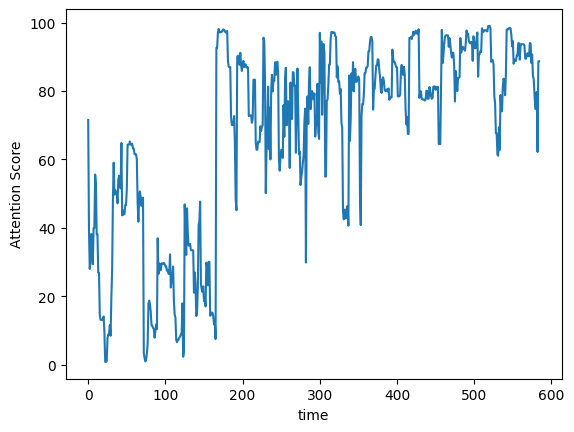

(585,)
(307199,)
585
(585,)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


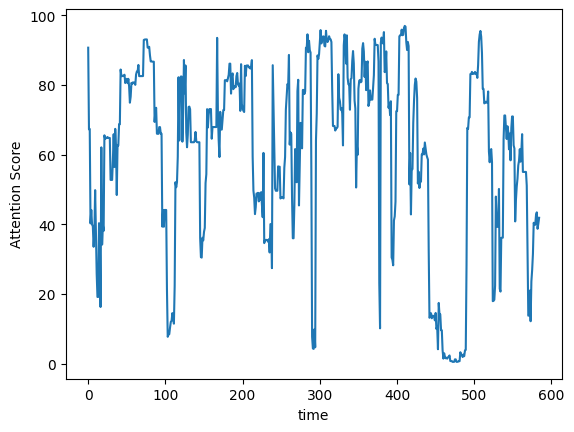

(585,)
(92159,)
165
(165,)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


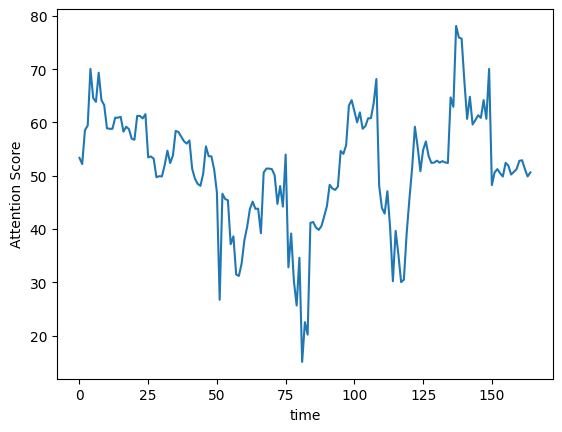

(165,)


In [15]:
paths = [
        "long_data/Subject_3.txt",
        "long_data/Subject_2.txt",
        "long_data/Subject_1_testmonham.txt",
]

labels = []
all_data = []

for path in paths:
    sub_data, label = checkProb(path, loaded_model)

    all_data.append(sub_data)
    labels.append(label)





In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Hàm tạo các sequence từ X và Y
def create_sequences(X, Y, timesteps = 20, window = 15):
    X_seq, Y_seq = [], []
    scaler_X = MinMaxScaler()
    # scaler_Y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    # Y_scaled = scaler_Y.fit_transform(Y)

    for i in range(len(X) - timesteps - window):
        X_seq.append(X_scaled[i:i + timesteps])
        Y_seq.append(Y[i + timesteps + window])

        # Y_seq = Y_seq[timesteps:]
    return np.array(X_seq), np.array(Y_seq)





In [17]:
# Tạo các sequence từ dữ liệu

X, Y = [], []
timesteps = 20
window = 15

for sub in range (len(all_data)):
    X_seq, Y_seq = create_sequences(all_data[sub], labels[sub], timesteps, window)
    X.append(X_seq)
    Y.append(Y_seq)


X = np.concatenate(X, axis = 0)
Y = np.concatenate(Y, axis = 0)

print(X.shape)
print(Y.shape)

# X_seq, Y_seq = create_sequences(X, Y, timesteps)

# Chia dữ liệu thành train/test với tỉ lệ 80:20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Reshape dữ liệu cho LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


(1230, 20, 20)
(1230,)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf


model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.5))  # Thêm Dropout
model.add(LSTM(16, activation='relu'))
model.add(Dropout(0.3))  # Thêm Dropout
model.add(Dense(1))  # Đầu ra là 1 giá trị duy nhất (dự đoán score)


def custom_mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

# Compile model với hàm MAPE loss tùy chỉnh
# model.compile(optimizer='adam', loss=custom_mape)
# Compile model
model.compile(optimizer='adam', loss='mse')

# Định nghĩa các callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, min_lr=0.003)

# Train model với callback
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[early_stopping, lr_scheduler], verbose=1)


# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention, Reshape, Concatenate
# import tensorflow as tf

# # Định nghĩa mô hình
# input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# # Hai lớp Dense đầu vào
# x = Dense(128, activation='relu')(input_layer)
# x = Dense(64, activation='relu')(x)

# # Hai lớp LSTM
# x = LSTM(64, activation='relu', return_sequences=True)(x)
# x = Dropout(0.5)(x)
# x = LSTM(32, activation='relu')(x)  # Đặt return_sequences=True để giữ định dạng 3 chiều
# x = Dropout(0.3)(x)

# # Hai lớp Dense để giảm chiều
# x = Dense(32, activation='relu')(x)
# x = Dense(16, activation='relu')(x)


# # Lớp đầu ra
# output_layer = Dense(1)(x)

# # Tạo mô hình
# model = Model(inputs=input_layer, outputs=output_layer)

# # Hàm loss tùy chỉnh MAPE
# def custom_mape(y_true, y_pred):
#     return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

# # Biên dịch mô hình
# model.compile(optimizer='adam', loss='mse')

# # Định nghĩa các callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, min_lr=0.003)

# # Huấn luyện mô hình
# history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), 
#                     callbacks=[early_stopping, lr_scheduler], verbose=1)



Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5088.6694 - val_loss: 4158.0181 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2280.5647 - val_loss: 786.3458 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1475.2961 - val_loss: 749.7029 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1301.5023 - val_loss: 582.3531 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1226.3871 - val_loss: 752.6301 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1141.2064 - val_loss: 520.2281 - learning_rate: 0.0010
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1117.9896 - val_loss: 531.7939 - learning_rate: 0.0010
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 978.0402 - val_loss: 784.2560 - learning_rate: 0.0010
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 980.0369 - val_loss: 601.7249 - learning_

In [22]:
# from tensorflow.keras.optimizers import Adam
# import keras_tuner as kt
# # Định nghĩa mô hình cho Keras Tuner
# def build_model(hp):
#     model = Sequential()
    
#     # LSTM layer 1
#     model.add(LSTM(
#         units=hp.Int('units_1', min_value=32, max_value=256, step=32),  # Số lượng units từ 32 đến 256
#         activation='relu',
#         input_shape=(X_train.shape[1], X_train.shape[2]),
#         return_sequences=True
#     ))
#     model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.7, step=0.1)))  # Dropout từ 0.2 đến 0.7
    
#     # LSTM layer 2
#     model.add(LSTM(
#         units=hp.Int('units_2', min_value=32, max_value=256, step=32),  # Tối ưu số units của LSTM thứ 2
#         activation='relu'
#     ))
#     model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.7, step=0.1)))  # Dropout từ 0.2 đến 0.7
    
#     # Dense layer
#     model.add(Dense(1))  # Đầu ra là một giá trị duy nhất

#     # Thiết lập optimizer với learning rate từ Keras Tuner
#     optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))

#     # Compile model với optimizer
#     model.compile(
#         optimizer=optimizer,
#         loss='mse'
#     )
    
#     return model


# # Khởi tạo tuner (Bayesian optimization, Random Search hoặc Hyperband)
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_loss',
#     max_epochs=50,
#     factor=3,
#     directory='my_dir',
#     project_name='tune_lstm'
# )

# # Định nghĩa các callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, min_lr=0.00001)

# # Tìm kiếm các tham số tốt nhất
# tuner.search(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test),
#              callbacks=[early_stopping, lr_scheduler], verbose=1)

# # Lấy mô hình tốt nhất
# best_model = tuner.get_best_models(num_models=1)[0]

# # Huấn luyện mô hình tốt nhất
# history = best_model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), 
#                          callbacks=[early_stopping, lr_scheduler], verbose=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Squared Error (MSE): 494.68688330633756
Mean Absolute Error (MAE): 17.467378417173315
Mean Absolute Percentage Error (MAPE): 452.11107126318853%
Symmetric Mean Absolute Percentage Error (sMAPE): 22.390726244848132%


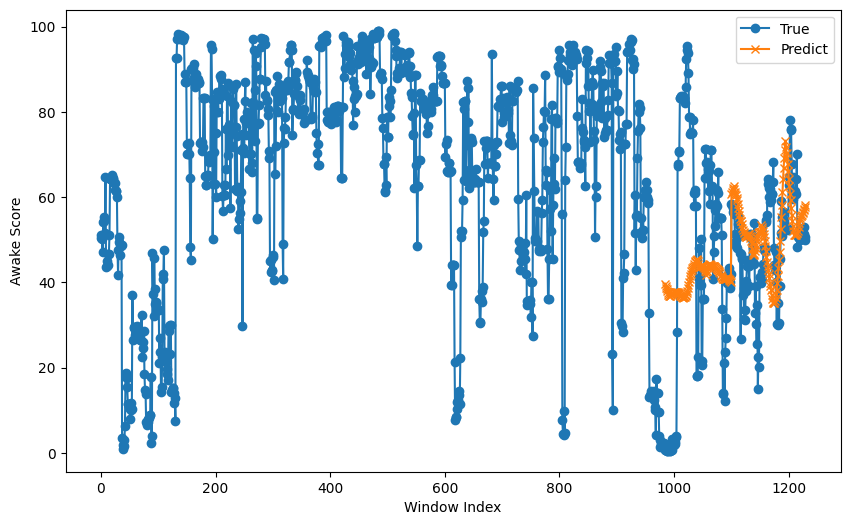

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero by adding a small value to the denominator if any y_true value is zero
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Filter out zero values in y_true to prevent divide-by-zero issues
    non_zero_indices = y_true != 0
    print(non_zero_indices.shape)
    y_true = y_true[non_zero_indices]
    y_pred = y_pred[non_zero_indices]
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mape(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    # Tránh chia cho 0 bằng cách thêm một số nhỏ
    denominator = np.abs(actual) + np.abs(forecast)
    sMAPE = 100 * np.mean(np.abs(forecast - actual) / (denominator + 1e-10))
    
    return sMAPE





Y_pred = model.predict(X_test)

# Chuyển đổi giá trị dự đoán về khoảng giá trị ban đầu
# Y_pred = scaler_Y.inverse_transform(Y_pred)
# Y_test = scaler_Y.inverse_transform(Y_test)

# Tính các chỉ số đánh giá
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
mape = custom_mape(Y_test, Y_pred)
smape = symmetric_mape(Y_test, Y_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape}%")


# Tạo mảng để chứa giá trị dự đoán
Y_pred_full = np.full(Y.shape[0], np.nan)
Y_pred_full[-len(Y_pred):] = Y_pred.flatten()

# Điền giá trị Y_pred vào mảng mới từ vị trí (len(Y_test) - len(Y_pred)) để căn ở bên phải
# Y_pred_full[len(Y_pred_full) - len(Y_pred):] = Y_pred.flatten()

# Vẽ biểu đồ giá trị thật và giá trị dự đoán với Y_pred được đẩy sang phải
plt.figure(figsize=(10, 6))
plt.plot(Y, label='True', marker='o')
plt.plot(Y_pred_full, label='Predict', marker='x')
# plt.title('So sánh giữa giá trị thật và dự đoán')
plt.xlabel('Window Index')
plt.ylabel('Awake Score')
plt.legend()
plt.show()

In [29]:
# Giả sử bạn đã có một mô hình LSTM đã được huấn luyện
model.save('lstm-forecast.h5')  # Lưu mô hình dưới dạng file HDF5


In [30]:
from keras.models import load_model

# Tải mô hình từ file
loaded_model = load_model('lstm-forecast.h5')


TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

In [37]:
X_sub3, Y_sub3 = create_sequences(all_data[0], labels[0], timesteps, window)
X_sub2, Y_sub2 = create_sequences(all_data[1], labels[1], timesteps, window)
X_sub1, Y_sub1 = create_sequences(all_data[2], labels[2], timesteps, window)



(130, 20, 20)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error (MSE): 837.2228802036037
Mean Absolute Error (MAE): 25.6504557041633
Mean Absolute Percentage Error (MAPE): 91.95825415421524%
Symmetric Mean Absolute Percentage Error (sMAPE): 26.93474310901965%


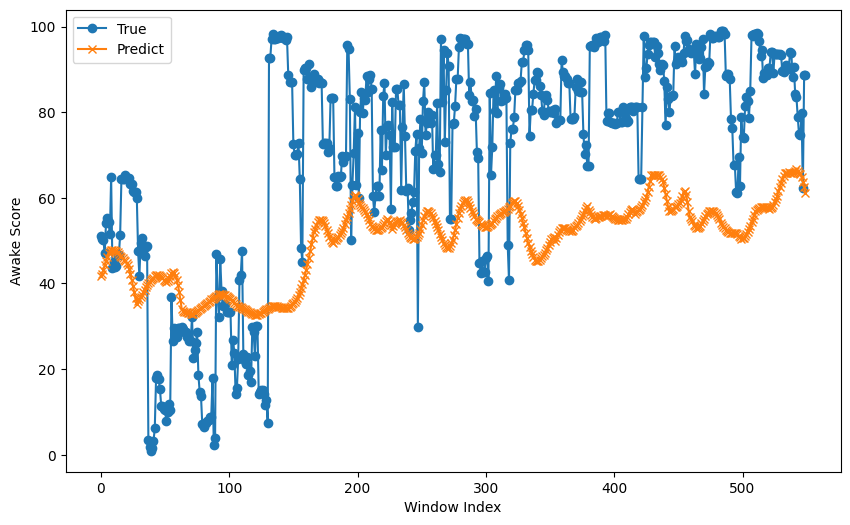

In [38]:
Y_pred_3 = model.predict(X_sub3)

# Chuyển đổi giá trị dự đoán về khoảng giá trị ban đầu
# Y_pred = scaler_Y.inverse_transform(Y_pred)
# Y_test = scaler_Y.inverse_transform(Y_test)

# Tính các chỉ số đánh giá
mse = mean_squared_error(Y_sub3, Y_pred_3)
mae = mean_absolute_error(Y_sub3, Y_pred_3)
mape = custom_mape(Y_sub3, Y_pred_3)
smape = symmetric_mape(Y_sub3, Y_pred_3)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape}%")


# Tạo mảng để chứa giá trị dự đoán
Y_pred_full = np.full(Y_sub3.shape[0], np.nan)
Y_pred_full[-len(Y_pred_3):] = Y_pred_3.flatten()

# Điền giá trị Y_pred vào mảng mới từ vị trí (len(Y_test) - len(Y_pred)) để căn ở bên phải
# Y_pred_full[len(Y_pred_full) - len(Y_pred):] = Y_pred.flatten()

# Vẽ biểu đồ giá trị thật và giá trị dự đoán với Y_pred được đẩy sang phải
plt.figure(figsize=(10, 6))
plt.plot(Y_sub3, label='True', marker='o')
plt.plot(Y_pred_full, label='Predict', marker='x')
# plt.title('So sánh giữa giá trị thật và dự đoán')
plt.xlabel('Window Index')
plt.ylabel('Awake Score')
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Squared Error (MSE): 891.2411550516237
Mean Absolute Error (MAE): 26.589809418639224
Mean Absolute Percentage Error (MAPE): 278.19744167279646%
Symmetric Mean Absolute Percentage Error (sMAPE): 28.593666391209126%


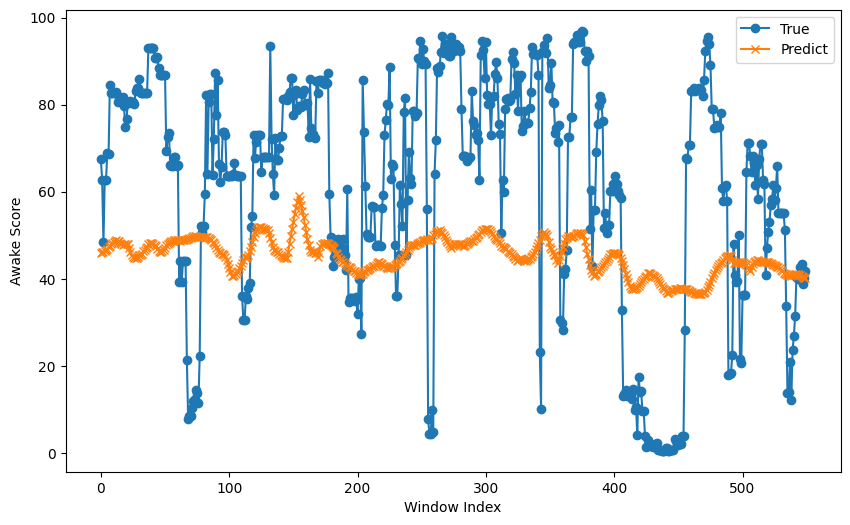

In [39]:
Y_pred_2 = model.predict(X_sub2)

# Chuyển đổi giá trị dự đoán về khoảng giá trị ban đầu
# Y_pred = scaler_Y.inverse_transform(Y_pred)
# Y_test = scaler_Y.inverse_transform(Y_test)

# Tính các chỉ số đánh giá
mse = mean_squared_error(Y_sub2, Y_pred_2)
mae = mean_absolute_error(Y_sub2, Y_pred_2)
mape = custom_mape(Y_sub2, Y_pred_2)
smape = symmetric_mape(Y_sub2, Y_pred_2)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape}%")


# Tạo mảng để chứa giá trị dự đoán
Y_pred_full = np.full(Y_sub2.shape[0], np.nan)
Y_pred_full[-len(Y_pred_2):] = Y_pred_2.flatten()

# Điền giá trị Y_pred vào mảng mới từ vị trí (len(Y_test) - len(Y_pred)) để căn ở bên phải
# Y_pred_full[len(Y_pred_full) - len(Y_pred):] = Y_pred.flatten()

# Vẽ biểu đồ giá trị thật và giá trị dự đoán với Y_pred được đẩy sang phải
plt.figure(figsize=(10, 6))
plt.plot(Y_sub2, label='True', marker='o')
plt.plot(Y_pred_full, label='Predict', marker='x')
# plt.title('So sánh giữa giá trị thật và dự đoán')
plt.xlabel('Window Index')
plt.ylabel('Awake Score')
plt.legend()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Squared Error (MSE): 168.2611722960228
Mean Absolute Error (MAE): 10.494975982513786
Mean Absolute Percentage Error (MAPE): 26.71738574109815%
Symmetric Mean Absolute Percentage Error (sMAPE): 11.260852993639729%


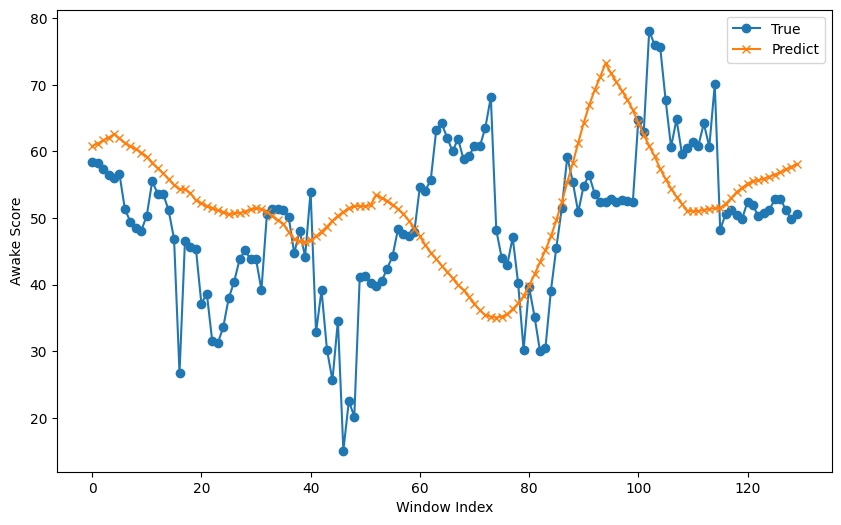

In [40]:
Y_pred_1 = model.predict(X_sub1)

# Chuyển đổi giá trị dự đoán về khoảng giá trị ban đầu
# Y_pred = scaler_Y.inverse_transform(Y_pred)
# Y_test = scaler_Y.inverse_transform(Y_test)

# Tính các chỉ số đánh giá
mse = mean_squared_error(Y_sub1, Y_pred_1)
mae = mean_absolute_error(Y_sub1, Y_pred_1)
mape = custom_mape(Y_sub1, Y_pred_1)
smape = symmetric_mape(Y_sub1, Y_pred_1)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape}%")


# Tạo mảng để chứa giá trị dự đoán
Y_pred_full = np.full(Y_sub1.shape[0], np.nan)
Y_pred_full[-len(Y_pred_1):] = Y_pred_1.flatten()

# Điền giá trị Y_pred vào mảng mới từ vị trí (len(Y_test) - len(Y_pred)) để căn ở bên phải
# Y_pred_full[len(Y_pred_full) - len(Y_pred):] = Y_pred.flatten()

# Vẽ biểu đồ giá trị thật và giá trị dự đoán với Y_pred được đẩy sang phải
plt.figure(figsize=(10, 6))
plt.plot(Y_sub1, label='True', marker='o')
plt.plot(Y_pred_full, label='Predict', marker='x')
# plt.title('So sánh giữa giá trị thật và dự đoán')
plt.xlabel('Window Index')
plt.ylabel('Awake Score')
plt.legend()
plt.show()